In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load data compued by "exp_covariancesEH.py"
#*****************************************************************************************************
with open('expts/exp_covarianceEH-QUBO_nq14-14_nsamples300_Gnm0.9.pkl', 'rb') as f: 
    avcov_qubo=pickle.load(f)
with open('expts/exp_covarianceEH-MAXCUT_nq14-14_nsamples155_Gnm0.9.pkl', 'rb') as f: 
    avcov_maxcut=pickle.load(f)
with open('expts/exp_covarianceEH-MAXCUT_nq14-14_nsamples145_Gnm0.9.pkl', 'rb') as f: 
    avcov_maxcut = pd.concat((avcov_maxcut, pickle.load(f)),ignore_index=True).reindex()
with open('expts/exp_covarianceEH-Random_Ising_nq14-14_nsamples155_Gnm0.9.pkl', 'rb') as f: 
    avcov_randomising=pickle.load(f)
with open('expts/exp_covarianceEH-Random_Ising_nq14-14_nsamples145_Gnm0.9.pkl', 'rb') as f: 
    avcov_randomising = pd.concat((avcov_randomising, pickle.load(f)),ignore_index=True).reindex()

In [5]:
# We sort the results in a new DataFrame. In data[i][j] the "i" identifies the sample, and "j" the average 
# covariance EH (sigmaEH) in each energy interval.
#*****************************************************************************************************
samples=300
N=14
raw_results = [avcov_qubo,avcov_maxcut,avcov_randomising]
results = []
for data in raw_results:
    dataframe = pd.DataFrame(columns=['Sample','Covariances','Energy Interval'])
    dataframe['Energy Interval']=[data['Normalized energy'][i][j] for i in range(samples) for j in range(2**N)]
    dataframe['Sample']=[data['Sample'][i][j] for i in range(samples) for j in range(2**N)]
    dataframe['Covariances']=[data['Covariances'][i][j] for i in range(samples) for j in range(2**N)]
    results.append(dataframe)

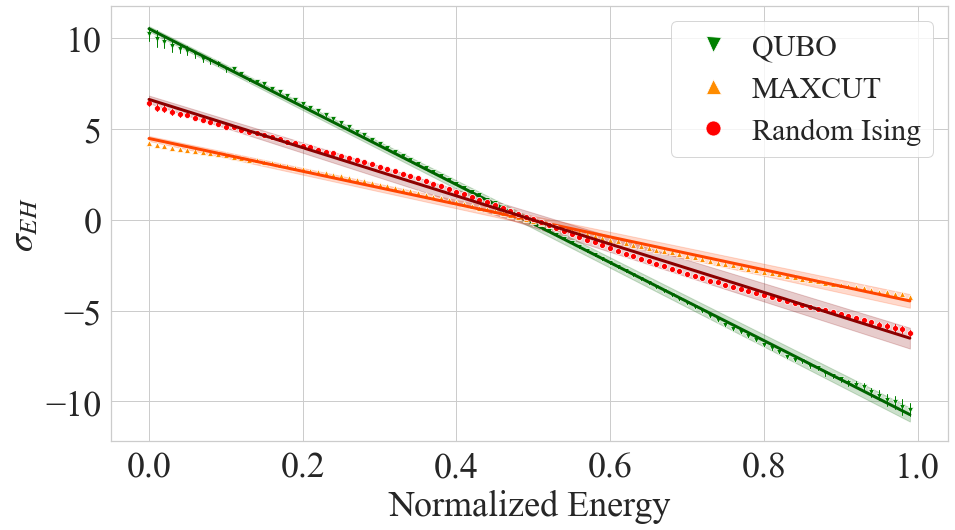

In [6]:
# Plot the results and perform the linear fit.
#*****************************************************************************************************

sns.set(rc={'figure.figsize':(15,8),"lines.linewidth": 1,"lines.markersize": 6,"font.family":"Times New Roman",
            'mathtext.fontset':"stix"},style='whitegrid')
fontsize = 36
fig, ax = plt.subplots()

problems = ['QUBO','MAXCUT','Random Ising']
nintervals = 100
energy_intervals = [j/nintervals for j in range(nintervals)]
colors_sc = ['green','darkorange','red']
colors_fit = ['darkgreen','orangered','darkred']
markers = ["v","^","o","<",">","8","s","P","p","*"]

for (problem,res,cl_sc,cl_fit,mark) in zip(problems,results,colors_sc,colors_fit,markers): 

    #PLOT
    plotsc = sns.lineplot(data=res, x="Energy Interval", y='Covariances',color=cl_sc,ax=ax,linestyle='',
                          err_style='bars',marker=mark,label=problem,ci=99)
    
    #FIT
    cov_means = [np.mean(res.loc[res['Energy Interval']==ei]['Covariances']) for ei in energy_intervals]
    p,cov = np.polyfit(energy_intervals,cov_means, 1,cov=True)
    perr = np.sqrt(np.diag(cov)) #standard deviation errors
    nstd2 = 5. # to draw nstd-sigma intervals (2-sigma=95%ci; 3-sigma=99.7%ci)
    popt_up2 = p + nstd2 * perr
    popt_dw2 = p - nstd2 * perr

    ax.plot(energy_intervals,np.polyval(p, energy_intervals),color=cl_fit,linewidth=3)#,label='Boltzmann Fit'
    ax.fill_between(energy_intervals,np.polyval(popt_up2, energy_intervals), 
                    np.polyval(popt_dw2, energy_intervals), color=cl_fit, alpha=.2)#label=r'5-$\sigma$ confidence interval'

ax.set_ylabel(r'$\sigma_{EH}$',fontsize=fontsize)
ax.set_xlabel(r'Normalized Energy',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.legend(fontsize=30,handletextpad=0.3,markerscale=2.5)

plt.savefig("pictures/average_cov_energy_fits_09den.svg")